In [ ]:
#------------------------------Mount Drive------------------------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import glob
from skimage.io import imread, imsave
from keras.models import model_from_json
from tensorflow.keras.models import load_model

In [ ]:
!unzip "/content/drive/MyDrive/deep learning/final results/test 1/sanity/sanity.zip" -d "/content"

Archive:  /content/drive/MyDrive/deep learning/final results/test 1/sanity/sanity.zip
   creating: /content/sanity/
   creating: /content/sanity/gt/
  inflating: /content/sanity/gt/01132-gt.png  
  inflating: /content/sanity/gt/01135-gt.png  
  inflating: /content/sanity/gt/01165-gt.png  
  inflating: /content/sanity/gt/0170-gt.png  
  inflating: /content/sanity/gt/02130-gt.png  
  inflating: /content/sanity/gt/02147-gt.png  
  inflating: /content/sanity/gt/02148-gt.png  
  inflating: /content/sanity/gt/02165-gt.png  
  inflating: /content/sanity/gt/0225-gt.png  
  inflating: /content/sanity/gt/0256-gt.png  
  inflating: /content/sanity/gt/1099-gt.png  
  inflating: /content/sanity/gt/1155-gt.png  
  inflating: /content/sanity/gt/1186-gt.png  
  inflating: /content/sanity/gt/12116-gt.png  
  inflating: /content/sanity/gt/12180-gt.png  
  inflating: /content/sanity/gt/12197-gt.png  
  inflating: /content/sanity/gt/1354-gt.png  
  inflating: /content/sanity/gt/1367-gt.png  
  inflating: 

In [ ]:
!ls '/content/sanity'

gt  ndwi  nir  rgb


In [ ]:
data_path = '/content/sanity/'
model_path = '/content/drive/MyDrive/deep learning/final results/models/'

In [ ]:
fnames = [os.path.basename(x)[:-7] for x in glob.glob(data_path+'gt/*.png')]

In [ ]:
rgb, nir, ndwi, gt = [], [], [], []
for name in fnames:
  rgb.append(imread(data_path+f'rgb/{name}-rgb.png'))
  gt.append(imread(data_path+f'gt/{name}-gt.png'))
  nir.append(imread(data_path+f'nir/{name}-nir.png'))
  ndwi.append(imread(data_path+f'ndwi/{name}-ndwi.png'))

nir = np.expand_dims(np.array(nir), axis=-1)
gt = np.array(gt)
rgb = np.array(rgb)
ndwi = np.expand_dims(np.array(ndwi), axis=-1)


print(rgb.shape, nir.shape, ndwi.shape, gt.shape)
print(rgb.dtype, nir.dtype, ndwi.dtype, gt.dtype)

(78, 512, 512, 3) (78, 512, 512, 1) (78, 512, 512, 1) (78, 512, 512)
uint8 uint8 uint8 uint8


In [ ]:
# data_path2 = '/content/drive/MyDrive/deep learning/final results/test 1/data/'
# with open(data_path2 + 'gt.pkl', 'rb') as pkl_file:
#   gt2 = pickle.load(pkl_file)[:, :, :, 1]
# print(gt2.dtype, gt2.shape)

uint8 (78, 512, 512)


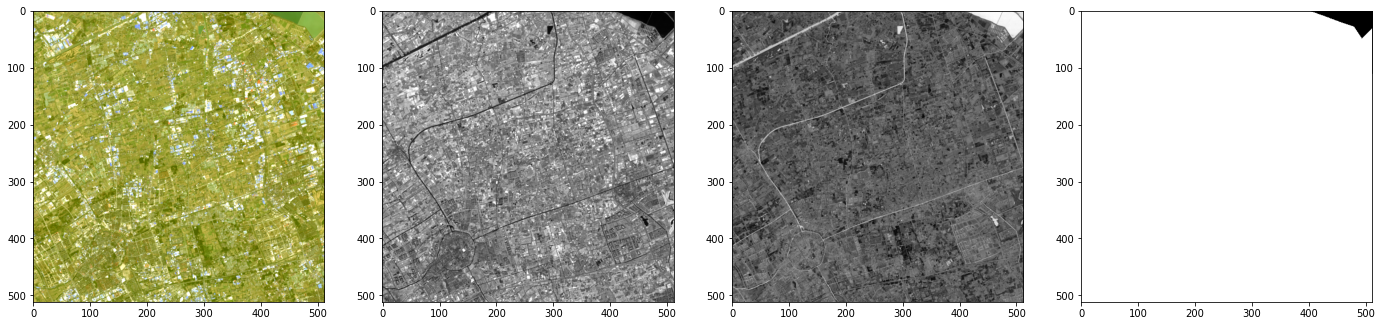

In [ ]:
num = np.random.randint(len(gt))
plt.figure(figsize=(24, 8))
plt.subplot(1, 4, 1)
plt.imshow(rgb[num])
plt.subplot(1, 4, 2)
plt.imshow(nir[num, :, :, 0], cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(ndwi[num, :, :, 0], cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(gt[num], cmap='gray')
plt.show()

In [ ]:
#---------------------------Confusion Matrix Function---------------------------
def confusion_mat(GT, Predict):
    assert len(np.unique(GT))<=2 and len(np.unique(Predict))<=2, \
    'inputs must have either two classes or one'
    
    GT, Predict = np.clip(GT, 0, 1), np.clip(Predict, 0, 1)
    # True Positive, False Positive
    TP = np.logical_and(GT==1, Predict==1)
    FP = np.logical_and(GT==0, Predict==1)
    # False Negative, True Negative
    FN = np.logical_and(GT==1, Predict==0)
    TN = np.logical_and(GT==0, Predict==0)
    
    # Validate Calculations
    assert np.array_equal(np.logical_xor.reduce((TP, FP, FN, TN)), np.ones_like(GT, dtype='bool')),\
    '------Calculations Invalid------'

    # Confusion Image
    confusion_img = np.zeros_like(GT, dtype='uint8')
    confusion_img[TP] = 1
    confusion_img[FP] = 2
    confusion_img[FN] = 3
    confusion_img[TN] = 4

    return [TP.sum(), FP.sum(), FN.sum(), TN.sum()], confusion_img


#---------------------------Metrics Function---------------------------
def _metrics(confusion_matrix):
  TP, FP = confusion_matrix[0], confusion_matrix[1]
  FN, TN = confusion_matrix[2], confusion_matrix[3]

  # sensitivity, recall, hit rate, or true positive rate (TPR)
  TPR = TP / (TP+FN)
  # precision or positive predictive value (PPV)
  PPV = TP / (TP+FP)
  # F1-score
  F1 = (2*PPV*TPR) / (PPV+TPR)
  # Intersection over Union (IoU)
  IoU = TP / (TP+FP+FN)
  # accuracy (ACC)
  ACC = (TP+TN) / (TP+TN+FP+FN)

  return [TPR, PPV, F1, IoU, ACC]

#---------------------------All Metrics---------------------------
def all_metrics(gt, prd):
  all_result = []
  for i in range(len(gt)):
    conf_mat, conf_img = confusion_mat(gt[i] ,prd[i])
    metrics = _metrics(conf_mat)
    all_result.append(metrics)

  all_result = np.array(all_result)
  all_result = np.nan_to_num(all_result)
  
  print('Total Number of Images: ', len(all_result))
  print('-------------------------------')
  f_result = np.mean(all_result, axis=0)
  print('Mean Metrics:')
  print('\tMean Accuracy:    {:.4f}'.format(f_result[4]))
  print('\tMean Sensitivity: {:.4f}'.format(f_result[0]))
  print('\tMean Precision:   {:.4f}'.format(f_result[1]))
  print('\tMean F1-Score:    {:.4f}'.format(f_result[2]))
  print('\tMean IoU:         {:.4f}'.format(f_result[3]))
  print('---------------------------------------------')

  return all_result

# deeplab

In [ ]:
model_deeplab = load_model(model_path + 'deeplab_model_43.h5', compile=False) #14, 15, 37, 44, 46

In [ ]:
output_dl = model_deeplab.predict(rgb, batch_size=3, verbose=1)

26/26 [==============================] - 123s 5s/step


In [ ]:
output_thr_dl = np.argmax(output_dl, axis=-1)
out_dl = all_metrics(gt, output_thr_dl)

Total Number of Images:  78
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9923
	Mean Sensitivity: 0.9472
	Mean Precision:   0.9809
	Mean F1-Score:    0.9566
	Mean IoU:         0.9315
---------------------------------------------


In [ ]:
for i, fname in enumerate(fnames):
  imsave(f'/content/drive/MyDrive/deep learning/final results/test 1/sanity/output/deeplab/{fname}-deeplab.png', output_thr_dl[i].astype('uint8')*255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/deeplab/2069-deeplab.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/deeplab/1963-deeplab.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/deeplab/23131-deeplab.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/deeplab/23161-deeplab.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/deeplab/2793-deeplab.png is a low contrast im

# fcdensenet

In [ ]:
model_fc = load_model(model_path + 'fcdensenet_model_23.h5', compile=False) #12

In [ ]:
output_fc = model_fc.predict(rgb, batch_size=3, verbose=1)

26/26 [==============================] - 344s 13s/step


In [ ]:
output_thr_fc = output_fc>0.5
out_fc = all_metrics(gt, output_thr_fc[:, :, :, 0].astype(int))

Total Number of Images:  78
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9707
	Mean Sensitivity: 0.9203
	Mean Precision:   0.9597
	Mean F1-Score:    0.9297
	Mean IoU:         0.8865
---------------------------------------------


In [ ]:
for i, fname in enumerate(fnames):
  imsave(f'/content/drive/MyDrive/deep learning/final results/test 1/sanity/output/fcdensenet/{fname}-fcdensenet.png', output_thr_fc[i].astype('uint8')*255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/fcdensenet/23131-fcdensenet.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/fcdensenet/23161-fcdensenet.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/fcdensenet/6107-fcdensenet.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/fcdensenet/1382-fcdensenet.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/fcdensenet/965-fcdens

# model 1 scenario 1

In [ ]:
# with open(model_path + 'scenario1_architecture.json', 'r') as json_file:
#   model_json = json_file.read()

# model1 = model_from_json(model_json)
# # model1.summary()
# model1.load_weights(model_path + 'scenario1_weights.hdf5')
# model1.save(model_path + 'model1_scenario1.h5')
model1 = load_model(model_path + 'model1_scenario1.h5', compile=False)

In [ ]:
output1 = model1.predict(rgb, verbose=1)

3/3 [==============================] - 155s 45s/step


In [ ]:
output_thr1 = output1>0.5
out1 = all_metrics(gt, output_thr1[:, :, :, 0].astype(int))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars


Total Number of Images:  78
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9935
	Mean Sensitivity: 0.9453
	Mean Precision:   0.9674
	Mean F1-Score:    0.9490
	Mean IoU:         0.9277
---------------------------------------------


In [ ]:
for i, fname in enumerate(fnames):
  imsave(f'/content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m1s1/{fname}-m1s1.png', output_thr1[i, :, :, 0].astype('uint8')*255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m1s1/2069-m1s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m1s1/1963-m1s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m1s1/23131-m1s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m1s1/23161-m1s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m1s1/2793-m1s1.png is a low contrast image
  
/usr/local/lib/python3.

# model 1 scenario 2

In [ ]:
# with open(model_path + 'scenario2_architecture.json', 'r') as json_file:
#   model_json = json_file.read()

# model2 = model_from_json(model_json)
# # model2.summary()
# model2.load_weights(model_path + 'scenario2_weights.hdf5')
# model2.save(model_path + 'model1_scenario2.h5')
model2 = load_model(model_path + 'model1_scenario2.h5', compile=False)

In [ ]:
input2 = ndwi.astype('float32') / 255
output2 = model2.predict(input2, verbose=1)

3/3 [==============================] - 152s 45s/step


In [ ]:
output_thr2 = output2>0.5
out2 = all_metrics(gt, output_thr2[:, :, :, 0].astype(int))

Total Number of Images:  78
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9910
	Mean Sensitivity: 0.9515
	Mean Precision:   0.9785
	Mean F1-Score:    0.9613
	Mean IoU:         0.9367
---------------------------------------------


In [ ]:
for i, fname in enumerate(fnames):
  imsave(f'/content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m1s2/{fname}-m1s2.png', output_thr2[i, :, :, 0].astype('uint8')*255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m1s2/2069-m1s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m1s2/1963-m1s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m1s2/23131-m1s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m1s2/23161-m1s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m1s2/2793-m1s2.png is a low contrast image
  
/usr/local/lib/python3.

# model 2 scenario 1

In [ ]:
model3 = load_model(model_path + 'model2_scenario1_038.h5', compile=False)

In [ ]:
input3 = np.concatenate((rgb, nir), axis=-1)
output3 = model3.predict(input3, verbose=1)

3/3 [==============================] - 138s 39s/step


In [ ]:
output_thr3 = output3>0.5
out3 = all_metrics(gt, output_thr3[:, :, :, 0].astype(int))

Total Number of Images:  78
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9934
	Mean Sensitivity: 0.9571
	Mean Precision:   0.9785
	Mean F1-Score:    0.9636
	Mean IoU:         0.9384
---------------------------------------------


In [ ]:
for i, fname in enumerate(fnames):
  imsave(f'/content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m2s1/{fname}-m2s1.png', output_thr3[i, :, :, 0].astype('uint8')*255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m2s1/1871-m2s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m2s1/6107-m2s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m2s1/1963-m2s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m2s1/23131-m2s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m2s1/4116-m2s1.png is a low contrast image
  
/usr/local/lib/python3.7

# model 2 scenario 2

In [ ]:
# with open(model_path + 'scenario3_architecture.json', 'r') as json_file:
#   model_json = json_file.read()

# model4 = model_from_json(model_json)
# # model4.summary()
# model4.load_weights(model_path + 'scenario3_weights.hdf5')
# model4.save(model_path + 'model2_scenario2.h5')
model4 = load_model(model_path + 'model2_scenario2.h5', compile=False)

In [ ]:
input4 = np.concatenate((rgb, nir), axis=-1)
output4 = model4.predict(input4, verbose=1)

3/3 [==============================] - 158s 45s/step


In [ ]:
output_thr4 = output4>0.5
out4 = all_metrics(gt, output_thr4[:, :, :, 0].astype(int))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars


Total Number of Images:  78
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9942
	Mean Sensitivity: 0.9616
	Mean Precision:   0.9680
	Mean F1-Score:    0.9640
	Mean IoU:         0.9445
---------------------------------------------


In [ ]:
for i, fname in enumerate(fnames):
  imsave(f'/content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m2s2/{fname}-m2s2.png', output_thr4[i, :, :, 0].astype('uint8')*255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m2s2/2069-m2s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m2s2/1963-m2s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m2s2/23131-m2s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m2s2/23161-m2s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m2s2/2793-m2s2.png is a low contrast image
  
/usr/local/lib/python3.

# model 3 scenario 1

In [ ]:
# with open(model_path + 'scenario4_architecture.json', 'r') as json_file:
#   model_json = json_file.read()

# model5 = model_from_json(model_json)
# # model5.summary()
# model5.load_weights(model_path + 'scenario4_weights.hdf5')
# model5.save(model_path + 'model3_scenario1.h5')
model5 = load_model(model_path + 'model3_scenario1.h5', compile=False)

In [ ]:
output5 = model5.predict(rgb, verbose=1)

3/3 [==============================] - 75s 21s/step


In [ ]:
output_thr5 = output5>0.5
out5 = all_metrics(gt, output_thr5[:, :, :, 1].astype(int))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars


Total Number of Images:  78
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9928
	Mean Sensitivity: 0.9606
	Mean Precision:   0.9649
	Mean F1-Score:    0.9620
	Mean IoU:         0.9408
---------------------------------------------


In [ ]:
for i, fname in enumerate(fnames):
  imsave(f'/content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m3s1/{fname}-m3s1.png', output_thr5[i, :, :, 1].astype('uint8')*255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m3s1/2069-m3s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m3s1/1963-m3s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m3s1/23131-m3s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m3s1/23161-m3s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m3s1/2793-m3s1.png is a low contrast image
  
/usr/local/lib/python3.

# model 3 scenario 2

In [ ]:
# with open(model_path + 'scenario5_architecture.json', 'r') as json_file:
#   model_json = json_file.read()

# model6 = model_from_json(model_json)
# # model6.summary()
# model6.load_weights(model_path + 'scenario5_weights.hdf5')
# model6.save(model_path + 'model3_scenario2.h5')
model6 = load_model(model_path + 'model3_scenario2.h5', compile=False)

In [ ]:
output6 = model6.predict(ndwi, verbose=1)

3/3 [==============================] - 77s 21s/step


In [ ]:
output_thr6 = output6>0.5
out6 = all_metrics(gt, output_thr6[:, :, :, 1].astype(int))

Total Number of Images:  78
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9901
	Mean Sensitivity: 0.9494
	Mean Precision:   0.9785
	Mean F1-Score:    0.9576
	Mean IoU:         0.9318
---------------------------------------------


In [ ]:
for i, fname in enumerate(fnames):
  imsave(f'/content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m3s2/{fname}-m3s2.png', output_thr6[i, :, :, 1].astype('uint8')*255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m3s2/2069-m3s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m3s2/1963-m3s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m3s2/23131-m3s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m3s2/23161-m3s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m3s2/2793-m3s2.png is a low contrast image
  
/usr/local/lib/python3.

# model 4 scenario 1

In [ ]:
model7 = load_model(model_path + 'model4_scenario1_018.h5', compile=False)

In [ ]:
output7 = model7.predict([rgb, nir], verbose=1)

3/3 [==============================] - 212s 61s/step


In [ ]:
output_thr7 = output7>0.5
out7 = all_metrics(gt, output_thr7[:, :, :, 0].astype(int))

Total Number of Images:  78
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9909
	Mean Sensitivity: 0.9612
	Mean Precision:   0.9733
	Mean F1-Score:    0.9647
	Mean IoU:         0.9375
---------------------------------------------


In [ ]:
for i, fname in enumerate(fnames):
  imsave(f'/content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m4s1/{fname}-m4s1.png', output_thr7[i, :, :, 0].astype('uint8')*255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m4s1/1871-m4s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m4s1/6107-m4s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m4s1/1963-m4s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m4s1/23131-m4s1.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m4s1/4116-m4s1.png is a low contrast image
  
/usr/local/lib/python3.7

# model 4 scenario 2

In [ ]:
# with open(model_path + 'scenario6_architecture.json', 'r') as json_file:
#   model_json = json_file.read()

# model8 = model_from_json(model_json)
# # model8.summary()
# model8.load_weights(model_path + 'scenario6_weights.hdf5')
# model8.save(model_path + 'model4_scenario2.h5')
model8 = load_model(model_path + 'model4_scenario2.h5', compile=False)

In [ ]:
output8 = model8.predict([rgb, nir], verbose=1)

3/3 [==============================] - 232s 67s/step


In [ ]:
output_thr8 = output8>0.5
out8 = all_metrics(gt, output_thr8[:, :, :, 0].astype(int))

Total Number of Images:  78
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9935
	Mean Sensitivity: 0.9584
	Mean Precision:   0.9757
	Mean F1-Score:    0.9599
	Mean IoU:         0.9395
---------------------------------------------


In [ ]:
for i, fname in enumerate(fnames):
  imsave(f'/content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m4s2/{fname}-m4s2.png', output_thr8[i, :, :, 0].astype('uint8')*255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m4s2/2069-m4s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m4s2/1963-m4s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m4s2/23131-m4s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m4s2/23161-m4s2.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/MyDrive/deep learning/final results/test 1/sanity/output/m4s2/2793-m4s2.png is a low contrast image
  
/usr/local/lib/python3.